## Importing libraries

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown
import geopandas
import plotly.express as px
import numpy
import seaborn as sns
import os

In [62]:
crime_table = pd.read_csv("../Data/crime/crime_statistics.csv")
filtered = crime_table[crime_table["Unit of measure"] == "Per hundred thousand inhabitants"]
filtered["TIME_PERIOD"] = filtered["TIME_PERIOD"].astype(int)
years = sorted(filtered["TIME_PERIOD"].unique())
states=crime_table["Geopolitical entity (reporting)"].unique()
grouped = (
    filtered.groupby(["Geopolitical entity (reporting)", "TIME_PERIOD"])["OBS_VALUE"]
    .sum()
    .reset_index()
    .rename(columns={
        "TIME_PERIOD": "Year",
        "Geopolitical entity (reporting)": "Country",
        "OBS_VALUE": "Total_Crime"
    })
)
#print(crime_table["Geopolitical entity (reporting)"].unique())
eu_data = grouped[grouped["Country"].isin(states)]
eu_mean = (
    eu_data.groupby("Year")["Total_Crime"]
    .mean()
    .reindex(years, fill_value=0)
    .reset_index()
    .rename(columns={"Total_Crime": "EU_Mean"})
)

y_min = grouped["Total_Crime"].min()
y_max = grouped["Total_Crime"].max()
padding = (y_max - y_min) * 0.05
y_min -= padding
y_max += padding

# for state in grouped["Country"].unique():
#     country_data = (
#         grouped[grouped["Country"] == state]
#         .set_index("Year")
#         .reindex(years, fill_value=0)
#         .reset_index()
#     )

#     plt.figure()
#     plt.plot(country_data["Year"], country_data["Total_Crime"], label=state, marker='o')
#     plt.plot(eu_mean["Year"], eu_mean["EU_Mean"], label="EU Mean", linestyle='--', color='red')

#     plt.title(f"Total Crime per Year in {state}")
#     plt.xlabel("Year")
#     plt.ylabel("Total Crime (per 100,000 inhabitants)")
#     plt.ylim(y_min, y_max)
#     plt.xticks(years, rotation=45)
#     plt.grid(True)
#     plt.legend()
#     plt.tight_layout()
#     output_dir = os.path.join("..", "Images", "Countries", state)
#     file_name = f"crime_rate_{state}.png"
#     file_path = os.path.join(output_dir, file_name)
    # if os.path.isdir(output_dir):
    #     plt.savefig(file_path)
    # else:
    #     print(f"Directory not found for {state}: {output_dir}")

    # plt.show()



C:\Users\erik3\AppData\Local\Temp\ipykernel_22464\2775197425.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered["TIME_PERIOD"] = filtered["TIME_PERIOD"].astype(int)


#### Using Jacob's draw_choropleth function and creating choropleth graphs

In [ ]:
def draw_choropleth(data, column,range=None,save_name=None,title="",color_scheme=None):
  if color_scheme is None:
    cmap = "Plasma"
  else:
    cmap = color_scheme
    
  if range is not None:
    fig = px.choropleth(
      data, locations=data.index, color=column,
      projection = "azimuthal equidistant",
      range_color=range,
      color_continuous_scale=cmap
    )
  else:
      fig = px.choropleth(
      data, locations=data.index, color=column,
      projection = "azimuthal equidistant",
      color_continuous_scale=cmap
      )

  fig.update_geos(lonaxis_range= [-20, 40],lataxis_range= [30, 72])
  fig.update_layout(height=500, margin={"r":0,"t":50,"l":0,"b":30},
                    title={
        'text': title,
        'y':0.96,  # Position from top (0 to 1)
        'x':0.5,    # Center the title
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=18) })
  fig.show()

country_iso_dict = {
    'Albania': 'ALB',
    'Austria': 'AUT',
    'Bosnia and Herzegovina': 'BIH',
    'Belgium': 'BEL',
    'Bulgaria': 'BGR',
    'Switzerland': 'CHE',
    'Cyprus': 'CYP',
    'Czechia': 'CZE',
    'Germany': 'DEU',
    'Denmark': 'DNK',
    'Estonia': 'EST',
    'Greece': 'GRC',
    'Spain': 'ESP',
    'Finland': 'FIN',
    'France': 'FRA',
    'Croatia': 'HRV',
    'Hungary': 'HUN',
    'Ireland': 'IRL',
    'Iceland': 'ISL',
    'Italy': 'ITA',
    'Liechtenstein': 'LIE',
    'Lithuania': 'LTU',
    'Luxembourg': 'LUX',
    'Latvia': 'LVA',
    'Montenegro': 'MNE',
    'North Macedonia': 'MKD',
    'Malta': 'MLT',
    'Netherlands': 'NLD',
    'Norway': 'NOR',
    'Poland': 'POL',
    'Portugal': 'PRT',
    'Romania': 'ROU',
    'Serbia': 'SRB',
    'Sweden': 'SWE',
    'Slovenia': 'SVN',
    'Slovakia': 'SVK',
    'Türkiye': 'TUR'
}



# for year in range(2014,2024):
#   map_data = grouped[grouped["Year"] == year].copy()
#   map_data['iso_alpha'] = map_data['Country'].map(country_iso_dict)
#   map_data.set_index("iso_alpha", inplace=True)
  # draw_choropleth(
  #     data=map_data,
  #     column="Total_Crime",
  #     title=f"Total Crime per 100,000 Inhabitants in {year}",
  #     color_scheme=["white","red","darkred"]
  # )


#### Getting ratios of people of type over the years
- Result is rounded to 2 decimal places


Documentation:
- get_ratio_dataframe expects one argument: *citizenship_type*. if left **None**, it will calculate all foreigners.
- citizenship_type can be in
    - **EU28_FOR**: EU28 countries (2013-2020) except reporting country
    - **NEU28_FOR**: Non-EU28 countries (2013-2020) nor reporting country
    - **NAT**: Reporting country
    - **STLS**: Stateless
    - **TOTAL**: Total
    - **UNK**: Unknown

In [64]:
year_offset = 4
def get_citizenship_ratio(table,country,citizenship_type):
    try:
        foreign_ratios = []
        country_main = table.query("Country =='"+country+"' and sex=='T' and citizen == 'TOTAL'")
        iso3 = country_main.iloc[0,1]

        if citizenship_type is not None:
            country_foreign = table.query("Country =='"+country+"' and sex=='T' and citizen == '"+citizenship_type+"'")
        
            for i in range(10):
                foreign_ratios.append((country_foreign.iloc[0,year_offset + i]/country_main.iloc[0,year_offset + i]*100))

        #Calculate all foreign residents
        else:
            country_natural = table.query("Country =='"+country+"' and sex=='T' and citizen == 'NAT'")
            for i in range(10):
                foreign_ratios.append((100-((country_natural.iloc[0,year_offset + i]/country_main.iloc[0,year_offset + i])*100)).round(2))
        
        years = [str(x+2015) for x in range(10)]

        series_data = [iso3] + foreign_ratios
        index_labels = ['ISO3'] + years
        
        return pd.Series(series_data, index=index_labels, name=country)
        
    except:
        print("Error processing country: ",country)
        return None
    
def get_ratio_dataframe(table,citizenship_type=None):
    results = []

    for country in table["Country"].unique():
        result = get_citizenship_ratio(table,country,citizenship_type)
        if result is not None:
            results.append(result.to_dict())

    return pd.DataFrame.from_records(results).set_index("ISO3")


#### Drawing heatmap

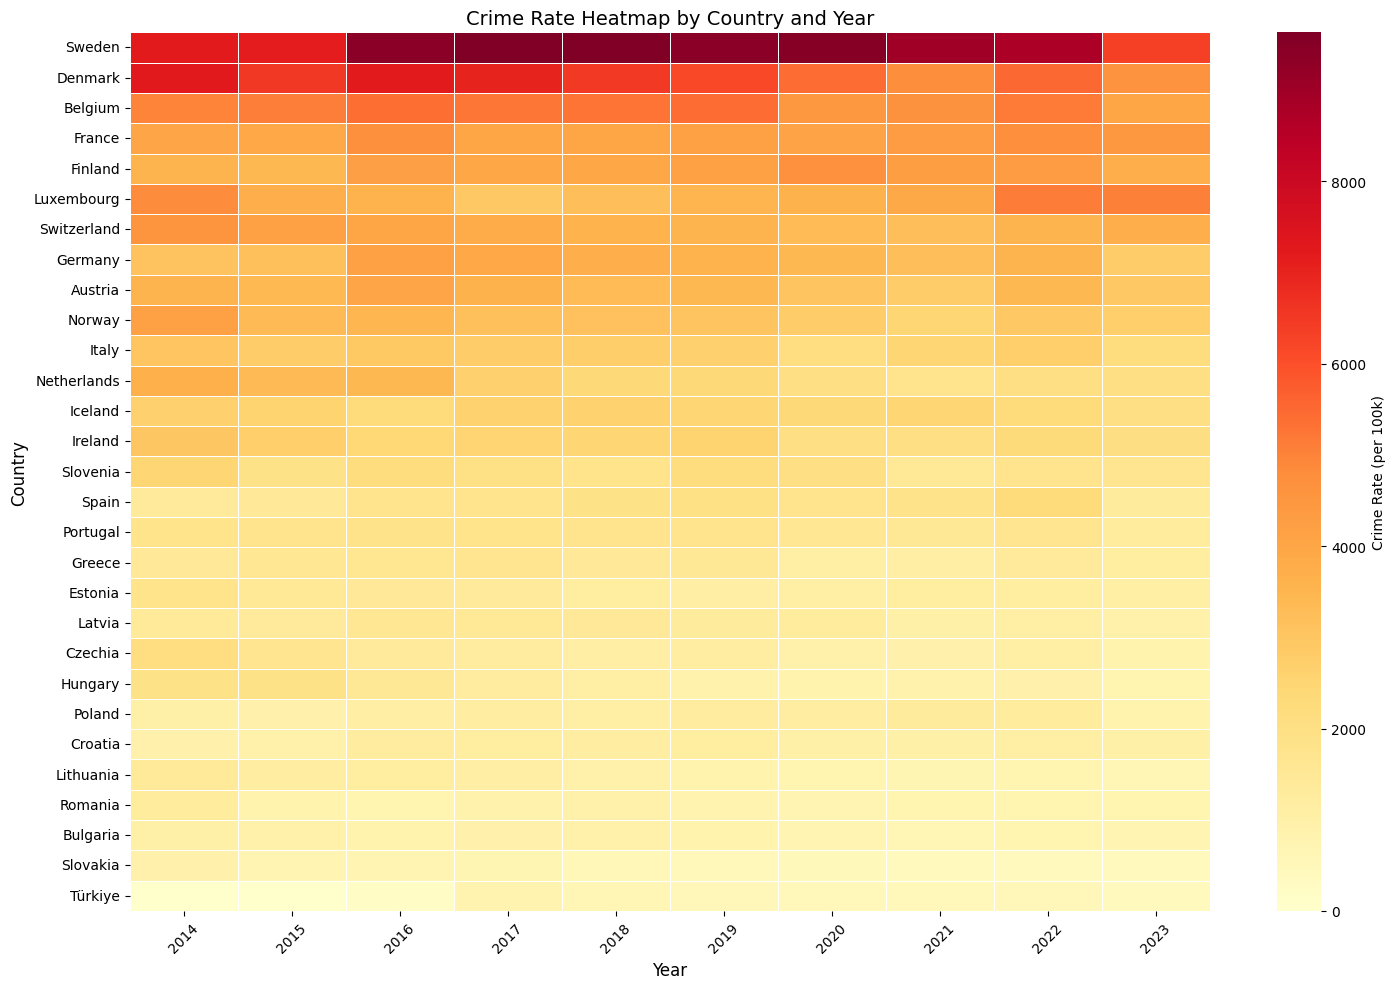

year,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
Country,,,,,,,,,,
Sweden,0.039912,0.042703,0.045443,0.051554,0.054732,0.057514,0.057723,0.055751,0.053229,0.050871
Denmark,0.041410,0.043179,0.046816,0.049362,0.050801,0.052085,0.052812,0.053861,0.054136,0.060135
Belgium,0.036681,0.037360,0.039857,0.041096,0.041501,0.042639,0.043917,0.044624,0.045628,0.051658
France,0.041729,0.045252,0.046448,0.046732,0.051534,0.052606,0.054425,0.056841,0.058434,0.059858
Finland,0.022358,0.023355,0.024263,0.026536,0.027344,0.028519,0.030063,0.032027,0.034323,0.038595
Luxembourg,0.062731,0.064710,0.068752,0.074239,0.077090,0.078048,0.081246,0.086478,0.089737,0.101865
Switzerland,0.081495,0.081828,0.082778,0.087509,0.088136,0.088344,0.088730,0.091596,0.092097,0.092949
Germany,0.047376,0.049944,0.058906,0.063886,0.066536,0.069129,0.071793,0.073505,0.076394,0.085559
Austria,0.063388,0.065973,0.073518,0.077328,0.078528,0.078787,0.079338,0.080535,0.082581,0.092541


Correlation Index Between Crime Rate and Non-EU Population for Each Country:
Country
Sweden         0.597546
Denmark       -0.849494
Belgium       -0.672495
France         0.503250
Finland        0.346870
Luxembourg     0.426231
Switzerland   -0.815063
Germany       -0.177908
Austria       -0.546449
Norway        -0.867409
Italy         -0.698448
Netherlands   -0.895740
Iceland       -0.777960
Ireland       -0.749169
Slovenia      -0.669198
Spain          0.064881
Portugal      -0.870211
Greece        -0.913176
Estonia       -0.000502
Latvia         0.691287
Czechia       -0.557078
Hungary       -0.889046
Poland         0.364283
Croatia       -0.170344
Lithuania     -0.505331
Romania       -0.208721
Bulgaria      -0.728676
Slovakia      -0.929461
Türkiye        0.197058
dtype: float64


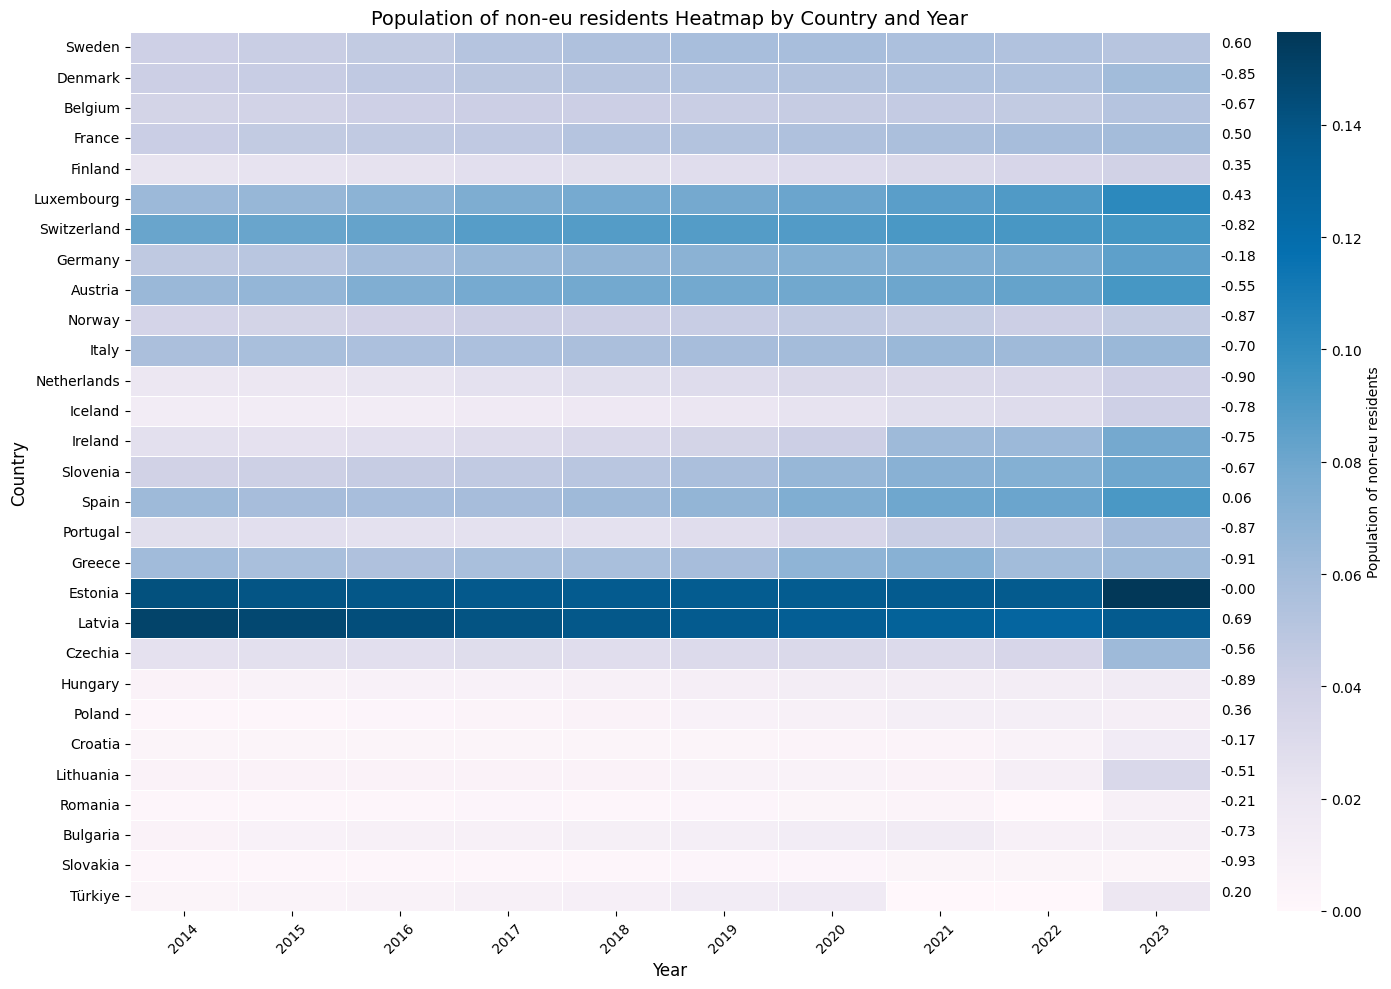

In [ ]:
countries_to_remove = [
    'England and Wales', 'Scotland (NUTS 2021)', 'Liechtenstein', 
    'Northern Ireland (UK) (NUTS 2021)', 'Malta', 'Serbia', 'Kosovo*', 'Cyprus', 'Albania', 
    'Montenegro', 'North Macedonia'
]

country_order = list(grouped.groupby("Country")["Total_Crime"].mean().sort_values(ascending=False).index)
country_order = [country for country in country_order if country not in countries_to_remove]

heatmap_data = grouped.pivot_table(
    index="Country",
    columns="Year",
    values="Total_Crime",
    fill_value=0
)
heatmap_data = heatmap_data.drop(index=countries_to_remove, errors='ignore')
heatmap_data = heatmap_data.loc[country_order]

def draw_heatmap(table, cmap, label, title, correlation=None):
    plt.figure(figsize=(15, 10))
    sns.heatmap(
        table,
        annot=False,
        cmap=cmap,
        linewidths=0.5,
        cbar_kws={"label": label}
    )

    if correlation is not None:
        for y, country in enumerate(table.index):
            if country in correlation.index:  # Ensure the country exists in the correlation data
                coef = correlation[country]
                plt.text(
                    x=table.shape[1] + 0.1 ,
                    y=y + 0.5,
                    s=f"{coef:.2f}", 
                    color="black", 
                    fontsize=10 
                )

    plt.title(title, fontsize=14)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Country", fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

draw_heatmap(heatmap_data,"YlOrRd","Crime Rate (per 100k)", "Crime Rate Heatmap by Country and Year")

# non-eu population
# Done by Erik

table_raw = pd.read_csv("../Data/immigration/non_eu_population.csv")
table_population = table_raw.query("citizen != 'TOTAL' and year != 2024 and Country not in ['Malta', 'Liechtenstein', 'Cyprus']")

heatmap_population = table_population.pivot_table(
    index="Country",
    columns="year",
    values="non_eu_portion",
    fill_value=0
)
heatmap_population = heatmap_population.loc[country_order]

display(heatmap_population)

# Calculate and display correlation for each country
correlation_per_country = heatmap_data.corrwith(heatmap_population, axis=1)
print("Correlation Index Between Crime Rate and Non-EU Population for Each Country:")
print(correlation_per_country)


draw_heatmap(heatmap_population,"PuBu","Population of non-eu residents", "Population of non-eu residents Heatmap by Country and Year",correlation_per_country)




